In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from dataclasses import dataclass
from collections import namedtuple, defaultdict
from markov import *
from base_models import *
from pos_encoder import *
from causal_graph import *
from config import *
from train import *
import plot
from util import memory_recall_probe, feedforward_probe
import seaborn as sns
import torch.utils.benchmark as benchmark
from tqdm.notebook import tqdm, trange

from head_view import *

%load_ext autoreload
%autoreload 2

In [8]:
def set_configs(seq_len, vocab_size, batch_size, num_epochs, emb_dim=None, pos_enc='rpe', flash=False):
    if emb_dim is None:
        emb_dim = max(16, 5*vocab_size)
    
    config = Config(
        emb_dim=emb_dim,
        num_layers=2,
        num_heads=(1,1),
        identity_query=False,
        seq_len=seq_len,
        vocab_size=vocab_size,
        batch_size=batch_size,
        num_epochs=num_epochs,
        eval_iter=500,
        pos_enc=pos_enc,
        pos_max_len=seq_len,
        get_attn=100,
        mlp=(False,False),
        activation=(False,False),
        flash=flash,
        ff_dim=emb_dim,
        layer_norm=False,
        ngram=2,
        learning_rate=2e-4,
        task_name='icl-mc',
        scheduler=False,
    )

    sampler_config = MarkovSamplerConfig(seq_len=seq_len, vocab_size=vocab_size, batch_size=batch_size, order=1, task_name='icl-mc')
    return config, sampler_config

#### Positional Encoding: RPE

In [13]:
seq_len = 50
vocab_size = 3
batch_size = 128

config, sampler_config = set_configs(seq_len, vocab_size, batch_size, 30000)
model = Transformer(config).to(config.device)
train_results = train_model_with_plot(model, config, sampler_config)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

GIF saved at attns_plot/l2h1v3_L0H0icl-mc_20250204_233208.gif
Folder 'attns' and its contents removed.


  0%|          | 0/300 [00:00<?, ?it/s]

GIF saved at attns_plot/l2h1v3_L1H0icl-mc_20250204_233304.gif
Folder 'attns' and its contents removed.


,


Loss plot saved at  loss_plots/l2h1_1v3icl-mc_20250204_234018.png


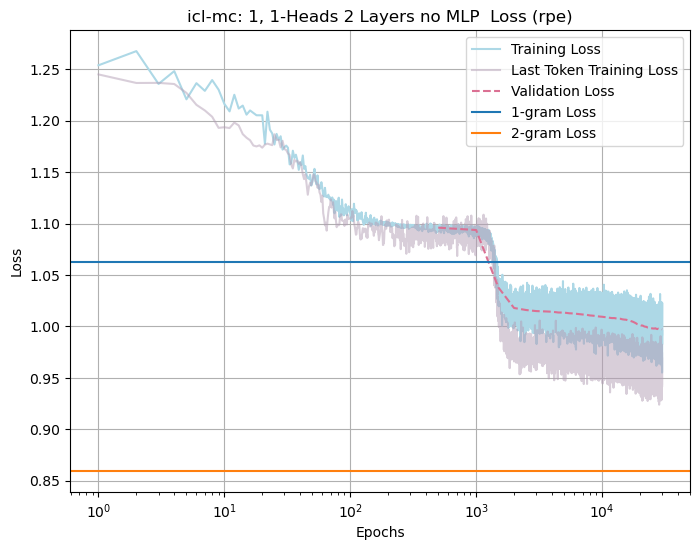

In [17]:
get_loss_plots(config, train_results, show=True)

In [15]:
get_head_view(model, train_results, config, trunc=10)

<IPython.core.display.Javascript object>

#### Vocabulary Size 4

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Loss plot saved at  loss_plots/l2h1_1v4icl-mc_20250205_002216.png


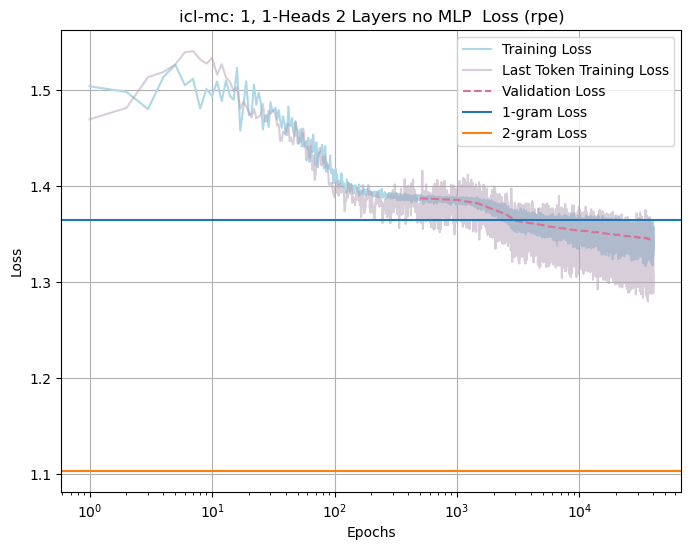

Creating images:   0%|          | 0/400 [00:00<?, ?it/s]

GIF saved at attns_plot/l2h1v4_L0H0icl-mc_20250205_002424.gif
Folder 'attns' and its contents removed.


Creating images:   0%|          | 0/400 [00:00<?, ?it/s]

GIF saved at attns_plot/l2h1v4_L1H0icl-mc_20250205_002636.gif
Folder 'attns' and its contents removed.


,


In [23]:
seq_len = 100
vocab_size = 4
batch_size = 64

config, sampler_config = set_configs(seq_len, vocab_size, batch_size, 40000)
model = Transformer(config).to(config.device)
train_results = train_model_with_plot(model, config, sampler_config)

In [25]:
get_head_view(model, train_results, config, trunc=0)

<IPython.core.display.Javascript object>

#### ABS

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Loss plot saved at  loss_plots/l2h1_1v3icl-mc_20250204_232300.png


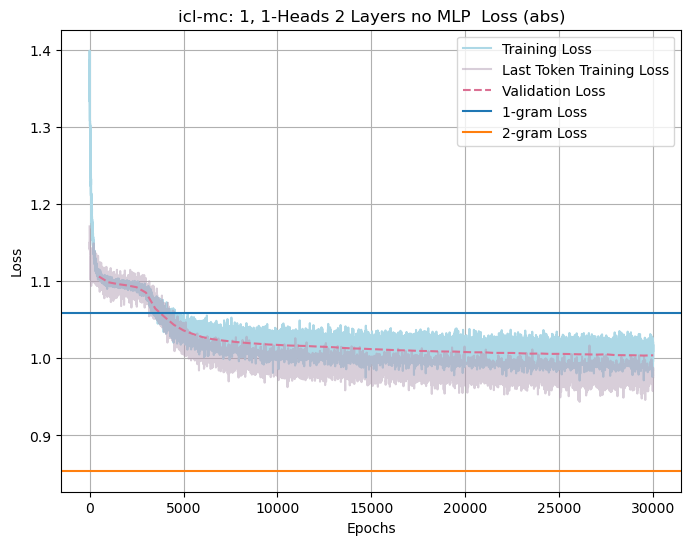

  0%|          | 0/300 [00:00<?, ?it/s]

GIF saved at attns_plot/l2h1v3_L0H0icl-mc_20250204_232355.gif
Folder 'attns' and its contents removed.


  0%|          | 0/300 [00:00<?, ?it/s]

GIF saved at attns_plot/l2h1v3_L1H0icl-mc_20250204_232452.gif
Folder 'attns' and its contents removed.


,


In [11]:
seq_len = 50
vocab_size = 3
batch_size = 128

config, sampler_config = set_configs(seq_len, vocab_size, batch_size, 30000, pos_enc='abs', flash=True)
model = Transformer(config).to(config.device)
train_results = train_model_with_plot(model, config, sampler_config)

In [12]:
get_head_view(model, train_results, config, trunc=0)

<IPython.core.display.Javascript object>